In [2]:
# Imports
import numpy as np
import math
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import acf, pacf, adfuller, grangercausalitytests
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf

In [3]:
# Getting data
brent = yf.Ticker("BZ=F")
wti = yf.Ticker("CL=F")
# Training period
train_start = datetime.datetime(2020, 7, 1)
train_end = datetime.datetime(2025, 8, 1)

# Cleaning the data
brent_data = brent.history(start = train_start, end = train_end).reset_index()
wti_data = wti.history(start = train_start, end = train_end).reset_index()

for index, row in brent_data.iterrows():
    if row['Date'] != wti_data.loc[index,'Date']:
        print(brent_data.iloc[index-1:index+2, 0])
        print(wti_data.iloc[index-1:index+2, 0])
        brent_data.drop(index, inplace = True)
        break

brent_data.drop(columns = ["Volume", "Dividends", "Stock Splits"], inplace = True)
brent_data = brent_data.set_index(["Date"])
wti_data.drop(columns = ["Volume", "Dividends", "Stock Splits"], inplace = True)
wti_data = wti_data.set_index("Date")

print("\nBrent Data")
print(brent_data.head(2))
print("\nWTI Data")
print(wti_data.head(2))

855   2023-11-22 00:00:00-05:00
856   2023-11-23 00:00:00-05:00
857   2023-11-24 00:00:00-05:00
Name: Date, dtype: datetime64[ns, America/New_York]
855   2023-11-22 00:00:00-05:00
856   2023-11-24 00:00:00-05:00
857   2023-11-27 00:00:00-05:00
Name: Date, dtype: datetime64[ns, America/New_York]

Brent Data
                                Open       High        Low      Close
Date                                                                 
2020-07-01 00:00:00-04:00  41.720001  42.619999  41.029999  42.029999
2020-07-02 00:00:00-04:00  42.020000  43.220001  41.750000  43.139999

WTI Data
                                Open       High        Low      Close
Date                                                                 
2020-07-01 00:00:00-04:00  39.840000  40.580002  39.049999  39.820000
2020-07-02 00:00:00-04:00  39.779999  40.740002  39.459999  40.650002


In [38]:
# Validation period
valid_start = datetime.datetime(2025, 7, 31)
valid_end = datetime.datetime(2025, 9, 1)

# Validation data
brent_valid_data = brent.history(start = valid_start, end = valid_end)
wti_valid_data = wti.history(start = valid_start, end = valid_end)

brent_valid_log_returns = np.log(brent_valid_data["Close"][1:] - brent_valid_data["Close"][:-1].values)
wti_valid_log_returns = np.log(wti_valid_data["Close"][1:] - wti_valid_data["Close"][:-1].values)

components = ["Open", "High", "Low", "Close"]
brent_valid_log_returns = pd.DataFrame()
wti_valid_log_returns = pd.DataFrame()
for comp in components:
    log_return = np.log(brent_valid_data[comp][1:] / brent_valid_data[comp][:-1].values)
    brent_valid_log_returns[comp] = log_return
    wti_log_return = np.log(wti_valid_data[comp][1:] / wti_valid_data[comp][:-1].values)
    wti_valid_log_returns[comp] = wti_log_return

print(brent_valid_log_returns.shape)
print(wti_valid_log_returns.shape)

(21, 4)
(21, 4)


c:\Users\User\AppData\Local\Programs\Python\Python314\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\User\AppData\Local\Programs\Python\Python314\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


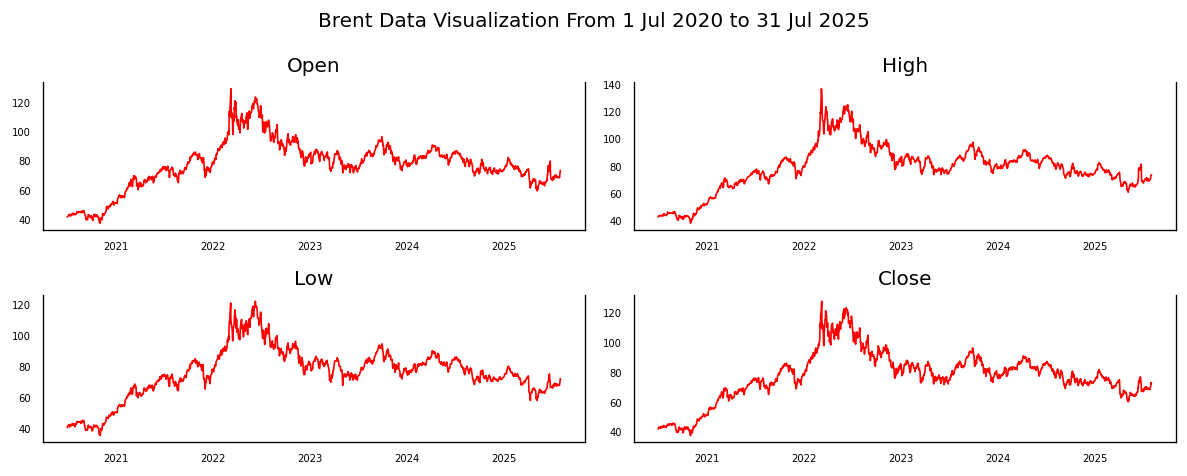

In [39]:
# Plotting Stock Price
fig, axes = plt.subplots(nrows = 2, ncols = 2, dpi = 120, figsize = (10, 4))
fig.suptitle("Brent Data Visualization From 1 Jul 2020 to 31 Jul 2025")
for i, ax in enumerate(axes.flatten()):
    data = brent_data[brent_data.columns[i]]
    ax.plot(data, color = "red", linewidth = 1)
    ax.set_title(brent_data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)
plt.tight_layout()

# From the plot, we can see that there's some correlation between WTI and Brent

In [40]:
# Check for stationarity in each component

components = ["Open", "High", "Low", "Close"]
for comp in components:
    adf_result = adfuller(brent_data[comp])
    print(comp)
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {adf_result[1]}\n")

Open
ADF Statistic: -2.193531374383842
p-value: 0.2086015662622998

High
ADF Statistic: -2.3588378925066906
p-value: 0.15369260840595478

Low
ADF Statistic: -2.415478626443425
p-value: 0.1374152539081439

Close
ADF Statistic: -2.1640161420917594
p-value: 0.21956367957220063



In [41]:
# Conclude no stationarity in each component
# Check for stationarity in Log Returns

print("Non stationary in data, checking for stationarity in log returns\n")
brent_log_returns = pd.DataFrame()
for comp in components:
    log_return = np.log(brent_data[comp][1:] / brent_data[comp][:-1].values)
    brent_log_returns[comp] = log_return
    adf_result = adfuller(log_return)
    print(f"{comp} Log Returns")
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {adf_result[1]}\n")

Non stationary in data, checking for stationarity in log returns

Open Log Returns
ADF Statistic: -12.525444200697347
p-value: 2.4946246502612954e-23

High Log Returns
ADF Statistic: -14.29805574594332
p-value: 1.2426426677791799e-26

Low Log Returns
ADF Statistic: -14.293402571280092
p-value: 1.2643180119939752e-26

Close Log Returns
ADF Statistic: -13.916971258472941
p-value: 5.381436585216011e-26



In [49]:
# Do the same for WTI Log Returns
wti_log_returns = pd.DataFrame()
for comp in components:
    log_return = np.log(wti_data[comp][1:] / wti_data[comp][:-1].values)
    wti_log_returns[comp] = log_return

In [42]:
# components = ["Open", "High", "Low", "Close"]
# Try to test High vs Close

def granger_test(comp1, comp2, dataset):
    print(f"""{comp2} causes {comp1} 
    - p-value > 0.05, fail to reject null hypothesis, suggesting no causal relationship
    - p-value <= 0.05, reject null hypothesis, conclude that {comp2} causes {comp1}""")
    return grangercausalitytests(dataset[[comp1, comp2]], 3)

granger_1 = granger_test("High", "Close", brent_log_returns)
granger_2 = granger_test("Close", "High", brent_log_returns)

print("There is strong evidence to suggest that Close causes High for all lags 1-3, but there is no evidence to suggest High causes Close")

Close causes High 
    - p-value > 0.05, fail to reject null hypothesis, suggesting no causal relationship
    - p-value <= 0.05, reject null hypothesis, conclude that Close causes High

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=711.6837, p=0.0000  , df_denom=1274, df_num=1
ssr based chi2 test:   chi2=713.3596, p=0.0000  , df=1
likelihood ratio test: chi2=566.7348, p=0.0000  , df=1
parameter F test:         F=711.6837, p=0.0000  , df_denom=1274, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=414.3077, p=0.0000  , df_denom=1271, df_num=2
ssr based chi2 test:   chi2=831.8751, p=0.0000  , df=2
likelihood ratio test: chi2=640.4885, p=0.0000  , df=2
parameter F test:         F=414.3077, p=0.0000  , df_denom=1271, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=290.7113, p=0.0000  , df_denom=1268, df_num=3
ssr based chi2 test:   chi2=876.9485, p=0.0000  , df=3
likelihood ratio test: chi2=667

In [76]:
brent_log_returns = brent_log_returns[["High", "Close"]]
brent_log_returns.shape

train_df = pd.DataFrame()
train_df["wti_close"] = wti_log_returns["Close"]
train_df["brent_close"] = brent_log_returns["Close"]
test_df = pd.DataFrame()
test_df["wti_close"] = wti_valid_log_returns["Close"]
test_df["brent_close"] = brent_valid_log_returns["Close"]

print(train_df.shape)
print(test_df.shape)

(1278, 2)
(21, 2)


In [77]:
granger_3 = grangercausalitytests(train_df[["wti_close", "brent_close"]], 3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1848  , p=0.6674  , df_denom=1274, df_num=1
ssr based chi2 test:   chi2=0.1852  , p=0.6669  , df=1
likelihood ratio test: chi2=0.1852  , p=0.6670  , df=1
parameter F test:         F=0.1848  , p=0.6674  , df_denom=1274, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0959  , p=0.9086  , df_denom=1271, df_num=2
ssr based chi2 test:   chi2=0.1925  , p=0.9082  , df=2
likelihood ratio test: chi2=0.1925  , p=0.9082  , df=2
parameter F test:         F=0.0959  , p=0.9086  , df_denom=1271, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0359  , p=0.9909  , df_denom=1268, df_num=3
ssr based chi2 test:   chi2=0.1084  , p=0.9908  , df=3
likelihood ratio test: chi2=0.1084  , p=0.9908  , df=3
parameter F test:         F=0.0359  , p=0.9909  , df_denom=1268, df_num=3


In [ ]:
granger_4 = grangercausalitytests(train_df[["brent_close", "wti_close"]], 3)
# This suggests that WTI_close affects Brent_close


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.8384  , p=0.0090  , df_denom=1274, df_num=1
ssr based chi2 test:   chi2=6.8545  , p=0.0088  , df=1
likelihood ratio test: chi2=6.8362  , p=0.0089  , df=1
parameter F test:         F=6.8384  , p=0.0090  , df_denom=1274, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4973  , p=0.0306  , df_denom=1271, df_num=2
ssr based chi2 test:   chi2=7.0221  , p=0.0299  , df=2
likelihood ratio test: chi2=7.0028  , p=0.0302  , df=2
parameter F test:         F=3.4973  , p=0.0306  , df_denom=1271, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.2261  , p=0.0834  , df_denom=1268, df_num=3
ssr based chi2 test:   chi2=6.7153  , p=0.0815  , df=3
likelihood ratio test: chi2=6.6976  , p=0.0822  , df=3
parameter F test:         F=2.2261  , p=0.0834  , df_denom=1268, df_num=3


In [54]:
model_VAR = VAR(train_df)

sorted_order = model_VAR.select_order(maxlags = 12)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -17.65      -17.64   2.163e-08      -17.65
1       -17.69     -17.67*   2.077e-08     -17.68*
2       -17.69      -17.65   2.070e-08      -17.68
3       -17.69      -17.63   2.078e-08      -17.67
4       -17.69      -17.61   2.085e-08      -17.66
5       -17.69      -17.60   2.086e-08      -17.65
6       -17.69      -17.58   2.083e-08      -17.65
7       -17.70      -17.57   2.065e-08      -17.65
8      -17.70*      -17.56  2.065e-08*      -17.64
9       -17.70      -17.54   2.065e-08      -17.64
10      -17.69      -17.52   2.069e-08      -17.63
11      -17.69      -17.50   2.078e-08      -17.62
12      -17.69      -17.49   2.075e-08      -17.61
--------------------------------------------------


c:\Users\User\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [55]:
model_VARMAX = VARMAX(train_df, order = (1, 0), enforce_stationarity = True)

fitted_model = model_VARMAX.fit(disp = False)
print(fitted_model.summary())

c:\Users\User\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                Statespace Model Results                                
Dep. Variable:     ['wti_close', 'brent_close']   No. Observations:                 1278
Model:                                   VAR(1)   Log Likelihood                7690.979
                                    + intercept   AIC                         -15363.958
Date:                          Sun, 26 Oct 2025   BIC                         -15317.581
Time:                                  21:16:08   HQIC                        -15346.542
Sample:                                       0                                         
                                         - 1278                                         
Covariance Type:                            opg                                         
Ljung-Box (L1) (Q):             0.00, 0.43   Jarque-Bera (JB):     407.99, 13063.85
Prob(Q):                        0.99, 0.51   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):        

In [70]:
n_forecast = len(test_df)

predict = fitted_model.get_prediction(start = len(train_df), end = len(train_df) + n_forecast - 1)
# Extracting predicted values
predictions = predict.predicted_mean
# Aligning prediction index with test data
predictions.index = test_df.index
# Renaming columns 
predictions.columns = ["Predicted_WTI_Close", "Predicted_Brent_Close"]

predictions.head()

c:\Users\User\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\User\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,Predicted_WTI_Close,Predicted_Brent_Close
Date,,
2025-08-01 00:00:00-04:00,0.000334,0.000061
2025-08-04 00:00:00-04:00,0.000443,0.000482
2025-08-05 00:00:00-04:00,0.000430,0.000415
2025-08-06 00:00:00-04:00,0.000432,0.000427
2025-08-07 00:00:00-04:00,0.000432,0.000425


In [65]:
actual_vs_pred = pd.concat([test_df, predictions], axis = 1)

actual_vs_pred.head()

,wti_close,brent_close,Predicted_WTI_Close,Predicted_Brent_Close
Date,,,,
2025-08-01 00:00:00-04:00,-0.028262,-0.040230,0.000334,0.000061
2025-08-04 00:00:00-04:00,-0.015567,-0.013148,0.000443,0.000482
2025-08-05 00:00:00-04:00,-0.017193,-0.016423,0.000430,0.000415
2025-08-06 00:00:00-04:00,-0.012509,-0.011150,0.000432,0.000427
2025-08-07 00:00:00-04:00,-0.007331,-0.006901,0.000432,0.000425


In [ ]:
# Trading strategy for Brent using WTI close values

portfolio_initial = 1000000

signal = None
for i in range(len(test_df)):
    predicted_log_return = actual_vs_pred["Predicted_Brent_Close"][i]
    actual_log_return = actual_vs_pred["brent_close"][i]
    if predicted_log_return - actual_log_return >= 0.001:
        signal = "buy"
    elif predicted_log_return - actual_log_return <= -0.001:
        signal = "sell"
    # Check if there is a signal, and set up portfolio accordingly
    # Will trade 1% of portfolio each time as an initial attempt
    if signal:
        trade_value = portfolio_initial * 0.01 
        if signal == "buy":
            pass
        else:
            pass
    break

6.128633676993103e-05
-0.04023046978479766


C:\Users\User\AppData\Local\Temp\ipykernel_8528\1588395744.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  expected_log_return = actual_vs_pred["Predicted_Brent_Close"][i]
C:\Users\User\AppData\Local\Temp\ipykernel_8528\1588395744.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  actual_log_return = actual_vs_pred["brent_close"][i]


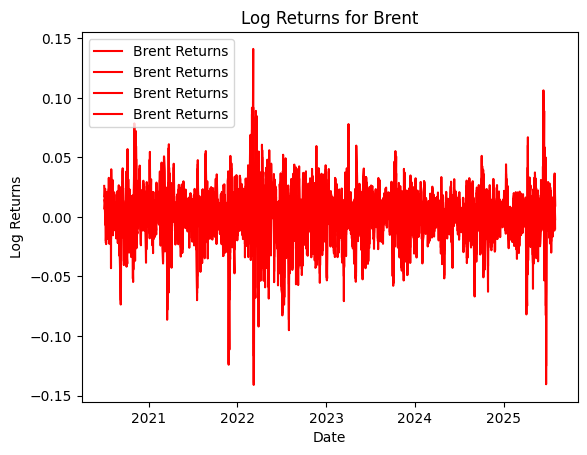

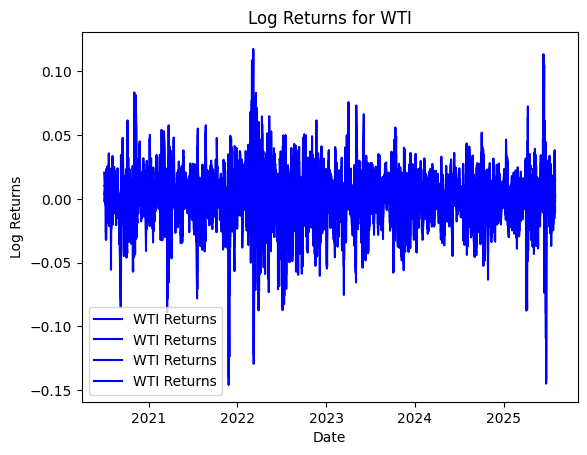

In [14]:
# We can try to track log returns on Brent
brent_log_returns = np.log(brent_data[1:] / brent_data[:-1].values)
wti_log_returns = np.log(wti_data[1:] / wti_data[:-1].values )

plt.plot(brent_log_returns, color = "red", label = "Brent Returns")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Log Returns")
plt.title("Log Returns for Brent")
plt.show()

plt.plot(wti_log_returns, color = "blue", label = "WTI Returns")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Log Returns")
plt.title("Log Returns for WTI")
plt.show()


Brent ACF Values: [ 1.          0.02143626 -0.03653014 -0.04206615 -0.00285669 -0.05904702
 -0.04869016 -0.0429175  -0.03329054 -0.01222157 -0.05394799  0.03130546
  0.06072577  0.03205936 -0.02106001  0.03019226]


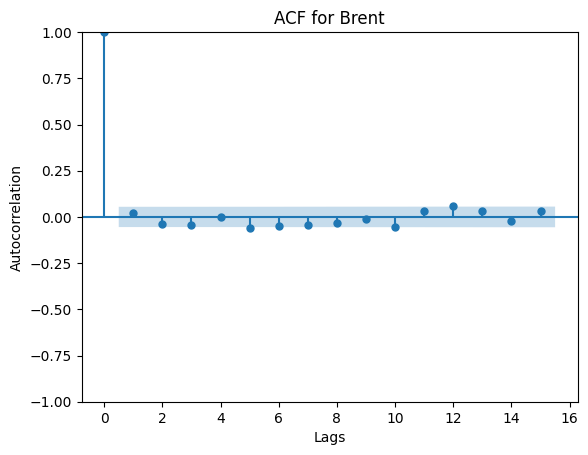

Brent PACF Values: [ 1.          0.02145304 -0.03706468 -0.04063047 -0.00245097 -0.06239796
 -0.04868537 -0.04651394 -0.04148182 -0.019734   -0.06612585  0.02213921
  0.04619969  0.01864297 -0.02346345  0.02699696]


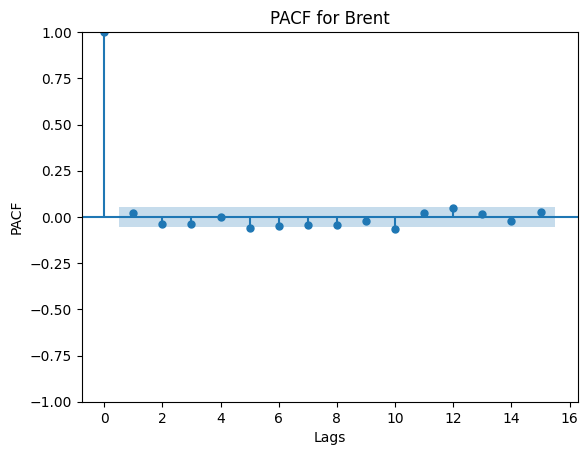

In [15]:
# We want to perform ACF / PACF tests on Brent first 
test_lag = 15
brent_log_returns = brent_log_returns["Close"]
brent_acf = acf(brent_log_returns, nlags = test_lag)
print("Brent ACF Values: {}".format(brent_acf))
plot_acf(brent_log_returns, lags = test_lag)
plt.title("ACF for Brent")
plt.xlabel("Lags")
plt.ylabel("Autocorrelation")
plt.show()
brent_pacf = pacf(brent_log_returns, nlags = test_lag)
print("Brent PACF Values: {}".format(brent_pacf))
plot_pacf(brent_log_returns, lags = test_lag)
plt.title("PACF for Brent")
plt.xlabel("Lags")
plt.ylabel("PACF")
plt.show()

WTI ACF Values: [ 1.          0.010042   -0.04538225 -0.032629   -0.00436352 -0.04229013
 -0.06234264 -0.03970233 -0.02534035 -0.01360639 -0.05480412  0.02635276
  0.05637083  0.03583315 -0.0218856   0.03474484]


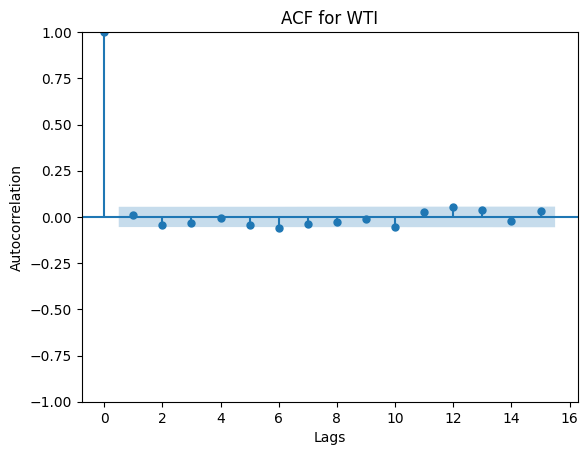

WTI PACF Values: [ 1.          0.01004986 -0.04555899 -0.0318396  -0.00583523 -0.0454377
 -0.06371062 -0.04381191 -0.03442255 -0.02280459 -0.0648422   0.01646494
  0.04152978  0.02571125 -0.02433236  0.03298945]


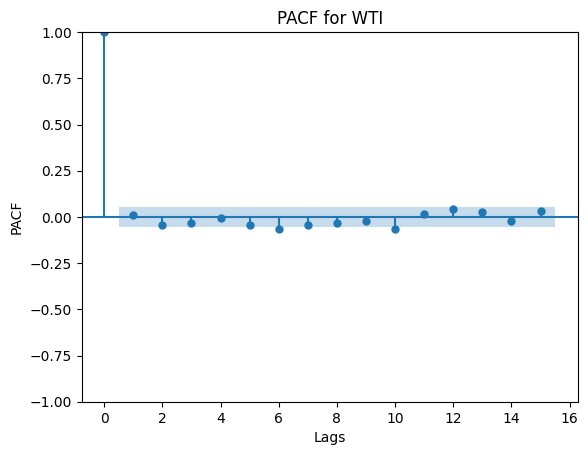

In [16]:
# Checking WTI shows similar results where there is no significant in lag
wti_log_returns = wti_log_returns["Close"]
wti_acf = acf(wti_log_returns, nlags = test_lag)
print("WTI ACF Values: {}".format(wti_acf))
plot_acf(wti_log_returns, lags = test_lag)
plt.title("ACF for WTI")
plt.xlabel("Lags")
plt.ylabel("Autocorrelation")
plt.show()
wti_pacf = pacf(wti_log_returns, nlags = test_lag)
print("WTI PACF Values: {}".format(wti_pacf))
plot_pacf(wti_log_returns, lags = test_lag)
plt.title("PACF for WTI")
plt.xlabel("Lags")
plt.ylabel("PACF")
plt.show()

In [17]:
def show_graph(df1,df2,title):
    data = pd.concat([df1, df2])
    data.reset_index(inplace=True, drop=True)
    for col in data.columns:
        if col.lower().startswith('pred'):
            data[col].plot(label=col,linestyle="dotted")
        else:
            data[col].plot(label=col)
    plt.title(title)
    plt.legend()
    plt.show()